# 07. bonniema/salary-predictor

## Model 1 : Use Word2Vec Embedding in Classification Models

## Import libraries and the final salary dataset

In [1]:
import time
from time import time
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Deep learning
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn

# Deep Learning - Mixed inputs
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop

%matplotlib inline
np.random.seed(0)

[nltk_data] Downloading package stopwords to C:\Users\Doğan Yiğit
[nltk_data]     Yenigün\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
salary_df = pd.read_csv('salary_final.csv')

In [3]:
print(salary_df.shape)
salary_df.head()

(1008, 25)


,Unnamed: 0.1,Unnamed: 0,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,...,adjusted_yearly_salary,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text
0,0,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,215000.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re..."
1,1,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,215000.0,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,"2021048 Data Scientist $215,000.00 Position Re..."
2,2,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,60000.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...
3,3,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,60000.0,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,Data Science/Data Analyst Cost Readiness Analy...
4,4,8,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,...,46800.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...


In [4]:
# While dropping duplicates, consider only 'Link' column for identifying duplicates and keep the first occurrence
salary_df = salary_df.drop_duplicates(subset='Link', keep='first')

In [5]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 0 to 1007
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0.1                    963 non-null    int64  
 1   Unnamed: 0                      963 non-null    int64  
 2   Title                           963 non-null    object 
 3   Company                         963 non-null    object 
 4   Link                            963 non-null    object 
 5   Review                          963 non-null    object 
 6   Salary                          963 non-null    object 
 7   Description                     963 non-null    object 
 8   Location2                       958 non-null    object 
 9   Rate_by                         963 non-null    object 
 10  low                             963 non-null    object 
 11  high                            762 non-null    object 
 12  min                             963

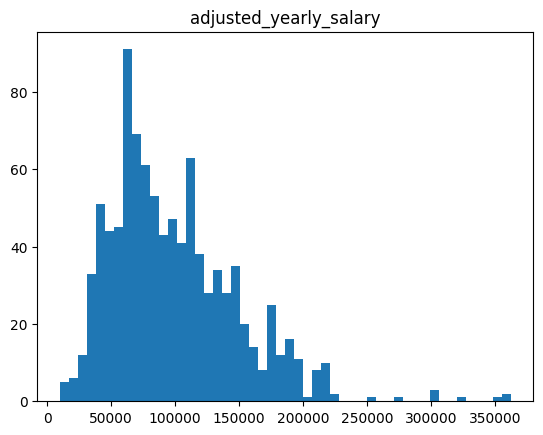

In [6]:
salary_df.hist('adjusted_yearly_salary', bins=50)
plt.grid(axis='both')
plt.show()

In [7]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

In [8]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,7)))

0.000000     10000.000000
0.166667     54026.666667
0.333333     70000.000000
0.500000     90000.000000
0.666667    114400.000000
0.833333    145600.000000
1.000000    362500.000000
Name: adjusted_yearly_salary, dtype: float64

In [9]:
# Create Bins
BINS = [0,50000,70000,90000,120000,150000,400000]

In [10]:
salary_df['Salary_Bins'] = pd.cut(x=salary_df['adjusted_yearly_salary'], bins=BINS, labels=False)
salary_df['Salary_Bins']

0       5
2       1
4       0
6       2
8       3
       ..
1003    3
1004    3
1005    3
1006    2
1007    2
Name: Salary_Bins, Length: 963, dtype: int64

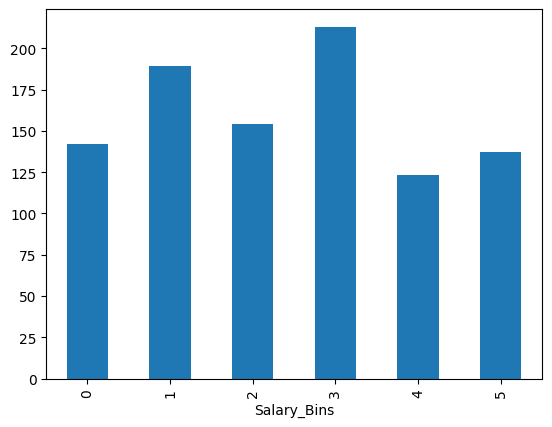

In [11]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()
plt.show()

In [12]:
# Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [13]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [14]:
data = clean_word(salary_df['combined_text'])

In [15]:
data

0      [data, scientist, position, requires, top, sec...
1      [data, science, data, analyst, cost, readiness...
2      [data, science, intern, job, title, data, scie...
3      [jr, data, scientist, ideal, candidate, degree...
4      [business, data, quality, engineer, please, no...
                             ...                        
958    [data, engineering, ii, data, engineering, ii,...
959    [ir, day, shift, tier, ir, day, shift, salary,...
960    [security, engineer, security, engineer, salar...
961    [fdp, analyst, position, title, fdp, analyst, ...
962    [junior, ms, access, vba, developer, want, acc...
Length: 963, dtype: object

In [16]:
data[5]

['data',
 'scientist',
 'job',
 'summary',
 'nsa',
 'search',
 'computer',
 'science',
 'professionals',
 'solve',
 'complex',
 'problems',
 'test',
 'innovative',
 'approaches',
 'research',
 'new',
 'solutions',
 'storing',
 'manipulating',
 'presenting',
 'information',
 'looking',
 'apply',
 'computer',
 'science',
 'expertise',
 'projects',
 'seek',
 'create',
 'new',
 'standards',
 'transformation',
 'information',
 'want',
 'develop',
 'technologies',
 'tools',
 'part',
 'cutting',
 'edge',
 'innovations',
 'join',
 'team',
 'experts',
 'help',
 'protect',
 'national',
 'security',
 'interests',
 'part',
 "world's",
 'advanced',
 'team',
 'computer',
 'science',
 'professionals',
 'qualifications',
 'candidates',
 "nsa's",
 'data',
 'scientist',
 'roles',
 'asked',
 'complete',
 'data',
 'science',
 'examination',
 'evaluating',
 'knowledge',
 'statistics',
 'mathematics',
 'computer',
 'science',
 'topics',
 'pertain',
 'data',
 'science',
 'work',
 'passing',
 'examination',
 

In [17]:
# SETUP DATA AND TARGET
data = clean_word(salary_df['combined_text'])
# target = salary_df['adjusted_yearly_salary']   # continuous target
target_class = salary_df['Salary_Bins'].astype('category')   # categorical target

In [18]:
# TRAIN TEST SPLIT
# Data is tokenized job descriptions, target_class is salary classes.
X_train, X_test, y_train, y_test = train_test_split(data, target_class, test_size=0.1, random_state=4)

In [58]:
X_train[0]

['data',
 'scientist',
 'position',
 'requires',
 'top',
 'secret',
 'ts',
 'sci',
 'clearance',
 'polygraph',
 'estimated',
 'salary',
 'position',
 'level',
 'level',
 'subject',
 'matter',
 'expert',
 'salary',
 'range',
 'per',
 'year',
 'b',
 'corp',
 'estimated',
 'salary',
 'ranges',
 'position',
 'level',
 'min',
 'salary',
 'max',
 'salary',
 'level',
 'subject',
 'matter',
 'expert',
 'level',
 'expert',
 'level',
 'senior',
 'level',
 'full',
 'performance',
 'mandatory',
 'requirements',
 'java',
 'development',
 'experience',
 'production',
 'environment',
 'required',
 'software',
 'developer',
 'list',
 'years',
 'experience',
 'demonstrated',
 'job',
 'experience',
 'troubleshooting',
 'user',
 'issues',
 'list',
 'years',
 'experience',
 'demonstrated',
 'job',
 'experience',
 'writing',
 'system',
 'automation',
 'scripts',
 'linux',
 'environment',
 'using',
 'tools',
 'bash',
 'sh',
 'python',
 'ruby',
 'perl',
 'list',
 'years',
 'experience',
 'demonstrated',
 'jo

## Model 1 : Use Word2Vec Embedding in Classification Models

This section will use Word2Vec model. Word2Vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks which are trained to reconstruct the linguistic contexts of words.

Word2Vec takes a large corpus of text as its input and produces a vector space (several hundred dimensions), with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

These parameters need to be specified in the model:
* `size` of the words we want to learn
* `window` size to use when training the model
* `min_count`, the minimum number of times a word must be used in the corpus in order to be included in the training (e.g. `min_count=5` means it would only learn word embeddings for words that appear >=5 times throughout the entire training set)
* `workers`, the number of threads to use for training, which can speed up processing (typically 4, since most processors can have at least 4 cores in recent years)

In [19]:
data[0][:30]

['data',
 'scientist',
 'position',
 'requires',
 'top',
 'secret',
 'ts',
 'sci',
 'clearance',
 'polygraph',
 'estimated',
 'salary',
 'position',
 'level',
 'level',
 'subject',
 'matter',
 'expert',
 'salary',
 'range',
 'per',
 'year',
 'b',
 'corp',
 'estimated',
 'salary',
 'ranges',
 'position',
 'level',
 'min']

In [20]:
# Word2Vec MODEL FROM SCRATCH
# Create a Word2Vec model with 100 dimensions
# vector_size = the number of dimensions of the N-dimensional space and Word2Vec maps the words into
# min_count = min frequency appeared in the corpus
w2v_model1 = Word2Vec(data, vector_size=64, window=10, min_count=10, workers=4)

In [21]:
w2v_model1.corpus_count

963

In [22]:
w2v_model1.train(data, total_examples=w2v_model1.corpus_count, epochs=10)

(2993285, 3458620)

In [23]:
wv = w2v_model1.wv  # KeyedVector

In [24]:
# After filtering for min frequency, how many words do we have in the corpus?
# words = list(wv.vocab)   # The vocab attribute was removed from KeyedVector in Gensim 4.x
words = list(wv.key_to_index)
print('Vocabulary size: %d' % len(words))
print(words[:20])

Vocabulary size: 3712
['data', 'experience', 'work', 'business', 'required', 'years', 'job', 'time', 'skills', 'team', 'management', 'ability', 'preferred', 'marketing', 'development', 'year', 'company', 'knowledge', 'requirements', 'position']


In [25]:
wv.most_similar('data')

[('unstructured', 0.6308798789978027),
 ('structured', 0.6294296383857727),
 ('extract', 0.5980398058891296),
 ('extraction', 0.5818955302238464),
 ('dashboards', 0.5701451897621155),
 ('disparate', 0.5670491456985474),
 ('modeling', 0.5534155368804932),
 ('reporting', 0.5494210124015808),
 ('sources', 0.5490368604660034),
 ('visualization', 0.5469928979873657)]

In [26]:
# To be able to use in the pipeline, we need to fit and transform
# First, wrap into a dictionary to use them in the pipeline
# w2v = dict(zip(w2v_model1.wv.index2word, w2v_model1.wv.vectors))  # index2word attribute has been replaced by index_to_key
w2v = dict(zip(w2v_model1.wv.index_to_key, w2v_model1.wv.vectors))

In [27]:
w2v['data']

array([-1.9521693 , -0.11708539, -0.8851786 ,  2.8365455 , -3.932914  ,
        1.454485  , -1.0654655 ,  1.0992069 , -1.4709699 , -0.7491498 ,
       -0.6735995 , -0.8719179 , -1.5954709 ,  2.265319  , -1.1237179 ,
       -2.6356995 ,  1.0229892 ,  0.09369324, -2.4821117 , -2.7825065 ,
        1.401822  ,  0.4826883 , -1.0451355 , -0.8366599 ,  3.9116583 ,
       -2.2404957 , -0.6452406 ,  1.1757452 , -1.6645281 , -1.7708896 ,
       -2.072053  , -1.3877076 ,  1.6195618 ,  1.4286985 ,  0.3938769 ,
        0.21903616,  0.8819638 , -1.4660003 ,  1.1416795 , -1.1477909 ,
       -1.6929485 , -0.8224991 , -2.189854  ,  0.8786388 , -1.5688412 ,
        1.8872147 , -3.39794   ,  2.9105911 ,  1.6769885 ,  0.48638755,
       -1.1986166 ,  1.7137743 , -2.0382936 , -0.56098264,  3.2272363 ,
       -2.6911392 , -0.38797942, -1.5181043 ,  1.7154782 ,  2.6602135 ,
       -3.9205813 , -0.11857559,  0.34566772,  0.49943945], dtype=float32)

In [28]:
len(w2v.values())

3712

In [29]:
# Averaging word vectors for all words in a text.
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # If a text is empty, we should return a vector of zeros with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X
        ])

### Use Word2Vec in the pipeline

In [30]:
# USE PIPELINE 
rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                ('Random Forest', RandomForestClassifier(n_estimators=50, criterion='entropy', verbose=True, n_jobs=3))])

svc = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                ('Support Vector Machine', SVC(kernel='rbf', C=0.5))])

sgd = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                ('Stochastic Gradient Descent', SGDClassifier(alpha=0.001, n_jobs=3))])

svr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                ('SVR-lin', SVR(kernel='rbf', C=0.5))])
                
lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
               ('Linear Regression', LinearRegression(n_jobs=3))])

In [31]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Stochastic Gradient Descent', sgd),
          ('SVR-lin', svr),
          ('Linear Regression', lr)]

In [32]:
scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model, in models]
scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished


[('Random Forest', 0.4284064665127021),
 ('Support Vector Machine', 0.3879907621247113),
 ('Stochastic Gradient Descent', 0.34988452655889146),
 ('SVR-lin', 0.45096349037927186),
 ('Linear Regression', 0.39269097348119725)]

In [33]:
# After several executions repeatedly, SVR performs the best! Random Forest comes after.
# Anyway, let's continue with Random Forest...
rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=3, 
                                                         verbose=True, n_jobs=3))])

In [34]:
cross_val_score(rf, X_train, y_train, cv=2).mean()

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


0.44688221709006926

In [35]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.2s finished


Pipeline(steps=[('Word2Vec Vectorizer',
                 <__main__.MeanEmbeddingVectorizer object at 0x00000162DA252CB0>),
                ('Random Forest',
                 RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                                        n_jobs=3, verbose=True))])

In [36]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


In [37]:
rf.score(X_test, y_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5463917525773195

In [38]:
proba_matrix = rf.predict_proba(X_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


In [39]:
proba_matrix.shape

(97, 6)

### Prediction probability of each bin

In [40]:
df_proba = pd.DataFrame(data = proba_matrix)

In [41]:
df_proba

,0,1,2,3,4,5
0,0.051667,0.115266,0.073643,0.363333,0.206706,0.189385
1,0.079786,0.196470,0.197624,0.320976,0.132406,0.072738
2,0.051429,0.239139,0.103595,0.292591,0.212865,0.100381
3,0.011083,0.145519,0.291409,0.295234,0.163278,0.093476
4,0.009333,0.009000,0.005429,0.054298,0.050083,0.871857
...,...,...,...,...,...,...
92,0.110131,0.288429,0.367321,0.165286,0.051167,0.017667
93,0.052012,0.400115,0.103560,0.193167,0.051488,0.199659
94,0.056352,0.109698,0.257135,0.316553,0.182734,0.077528
95,0.175333,0.296414,0.201986,0.188278,0.135488,0.002500


In [42]:
df_proba.describe()

,0,1,2,3,4,5
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.125880,0.196559,0.151903,0.220733,0.146650,0.158274
std,0.156444,0.153663,0.100326,0.145143,0.134430,0.222949
min,0.000000,0.000000,0.000000,0.003333,0.004500,0.000000
25%,0.030905,0.075869,0.071825,0.118020,0.069969,0.028095
50%,0.066560,0.183214,0.133040,0.198401,0.102667,0.080619
75%,0.160422,0.292524,0.215413,0.286030,0.182734,0.154691
max,0.716345,0.873040,0.454330,0.799667,0.901421,0.973000


### Random Forest with Grid Search

In [43]:
#Grid Search: Word2Vec with Random Forest Classifier
pipeline =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                      ('rf', RandomForestClassifier(n_jobs=3))])
parameters = {
    'rf__n_estimators': (30,40,50),
    'rf__criterion': ("gini","entropy"),
    'rf__min_samples_split': (2,6,8),
    'rf__max_features': ("auto","sqrt","log2")
}
                
if __name__ == "__main__":
    # Multiprocessing requires the fork to happen in a __main__ protected block
    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data, target_class)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['Word2Vec Vectorizer', 'rf']
parameters:
{'rf__criterion': ('gini', 'entropy'),
 'rf__max_features': ('auto', 'sqrt', 'log2'),
 'rf__min_samples_split': (2, 6, 8),
 'rf__n_estimators': (30, 40, 50)}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
done in 64.172s

Best score: 0.414
Best parameters set:
	rf__criterion: 'entropy'
	rf__max_features: 'log2'
	rf__min_samples_split: 8
	rf__n_estimators: 50


In [44]:
# Let's try another grid search
pipeline =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
                      ('rf', RandomForestClassifier(n_estimators = 30, criterion='gini', n_jobs=3, max_features='sqrt'))])
parameters = {
    'rf__class_weight': ("balanced",None),
    'rf__min_samples_split': (4,6),
    'rf__max_samples': (None,0.5,0.8,1)   
}
                
if __name__ == "__main__":
    # Multiprocessing requires the fork to happen in a __main__ protected block
    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['Word2Vec Vectorizer', 'rf']
parameters:
{'rf__class_weight': ('balanced', None),
 'rf__max_samples': (None, 0.5, 0.8, 1),
 'rf__min_samples_split': (4, 6)}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 16.533s

Best score: 0.472
Best parameters set:
	rf__class_weight: None
	rf__max_samples: None
	rf__min_samples_split: 4


In [45]:
# From these outcomes, the best score was improved from 0.42 to 0.47!
# So far, the combination of best parameters are:
# - rf__class_weight : 'balanced'
# - rf__max_samples : 0.8
# - rf__min_samples_split : 4
# - rf__criterion : 'gini'
# - rf__max_features : 'sqrt'
# - rf__n_estimators : 40

### SGD with Grid Search

In [46]:
# Try SGDClassifier 
pipeline = Pipeline([
    ('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
    ('clf', SGDClassifier(n_jobs=3, early_stopping=True, validation_fraction=0.2))])

# Uncommenting more parameters will give better exploring power but will increase processing time in a combinatorial way
parameters = {  
    'clf__alpha': (0.0001, 0.001, 0.01),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__l1_ratio': (0, 0.1, 0.3, 0.5),
    'clf__max_iter': (100,200,300)
}

if __name__ == "__main__":
    # Multiprocessing requires the fork to happen in a __main__ protected block
    # Find the best parameters for both the feature extraction and then classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['Word2Vec Vectorizer', 'clf']
parameters:
{'clf__alpha': (0.0001, 0.001, 0.01),
 'clf__l1_ratio': (0, 0.1, 0.3, 0.5),
 'clf__max_iter': (100, 200, 300),
 'clf__penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
done in 71.603s

Best score: 0.381
Best parameters set:
	clf__alpha: 0.01
	clf__l1_ratio: 0
	clf__max_iter: 200
	clf__penalty: 'elasticnet'


Well, SGD did not perform better than Random Forest!